In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, accuracy_score, auc

import statsmodels.api as sm

# Data Modeling

In [2]:
df = pd.read_csv('d_final.csv', encoding = 'utf-8')

In [3]:
df.head()

,id,sex,intubed,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,...,tobacco,contact_other_covid,covid_res,icu,DEATH,d_ent,d_sym,d_last,diff_days,age_grp
0,167386,1,2,2,54,2,2,2,2,2,...,2,3,1,2,0,2020-04-06,2020-04-01,2020-06-29,89,3.0
1,0b5948,2,2,1,30,2,2,2,2,2,...,2,3,1,2,0,2020-04-17,2020-04-10,2020-06-29,80,2.0
2,0d01b5,1,2,2,60,2,1,2,2,2,...,2,3,1,2,1,2020-04-13,2020-04-13,2020-04-22,9,4.0
3,1beec8,2,2,1,47,2,1,2,2,2,...,2,3,1,1,1,2020-04-16,2020-04-16,2020-04-29,13,3.0
4,1.75E+56,2,2,2,63,2,2,2,2,2,...,2,3,1,2,0,2020-04-22,2020-04-13,2020-06-29,77,4.0


In [4]:
df['DEATH'].value_counts()

0    88993
1    32402
Name: DEATH, dtype: int64

### 사망기간 예측을 위한 생존자 데이터 제거



In [5]:
df['DEATH'] = df['DEATH'].replace(0, np.nan)
df.dropna(inplace=True)

In [6]:
df['DEATH'].value_counts()

1.0    32402
Name: DEATH, dtype: int64

### 변수 설정

- 정규화할 변수만 독립변수 X에 저장
- 종속변수 Y는 정규화 안하고 저장

In [7]:
X = df[['sex', 'intubed','age_grp','pneumonia',
        'pregnancy', 'diabetes', 'copd', 'asthma',
        'inmsupr','hypertension','other_disease',
        'cardiovascular','obesity', 'renal_chronic', 
        'tobacco', 'contact_other_covid', 'covid_res', 
        'icu']]

Y = df['diff_days']

### 정규화

In [8]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(x_scaled)

##### train/test 데이터 셋 분리

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 1004)

In [10]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(25921, 18) (6481, 18) (25921,) (6481,)


### Tensorflow 탑재를 위한 차원 변경

- y의 시리즈 데이터를 데이터 프레임으로 변환

In [11]:
y_train2 = y_train.values.reshape(25921, 1)
y_test2 = y_test.values.reshape(6481, 1)

In [12]:
print(x_train.shape, y_train2.shape)
print(x_test.shape, y_test2.shape)

(25921, 18) (25921, 1)
(6481, 18) (6481, 1)


### Tensorflow 환경 설정
- Tensorflow 1 버전으로 작성
- multivariable linear regression 모델

##### 변수 선언

In [13]:
x = tf.placeholder(tf.float32, shape=[None, 18])
y = tf.placeholder(tf.float32, shape=[None, 1])

w = tf.Variable(tf.random_normal([18, 1]), name='weight')
b = tf.Variable(tf.random_normal([1]), name='bias')

##### 가설 함수 정의 ( Y = XW + B )

In [14]:
hypothesis = tf.matmul(x,w)+b

##### 손실 함수 정의 (MSE)

In [15]:
loss = tf.reduce_mean(tf.square(hypothesis - y))

##### 경사하강법 알고리즘

In [16]:
# train = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(loss)

In [17]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
train = optimizer.minimize(loss)

- learning_rate 값을 수정해서 손실 값 0에 가깝게 맞추면 된다.

In [18]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for step in range(6001):
        loss_val, hy_val, _ = sess.run([loss, hypothesis, train],
                                       feed_dict={x:x_train, y:y_train2})
        
        if step % 200 == 0:
            print(step, "\n Loss: ", loss_val, "\n accur: \n", hy_val)
            
    pred = sess.run(hypothesis, feed_dict={x:x_test})
    print("\nTest-set: \n", pred)

0 
 Loss:  95.33355 
 accur: 
 [[4.3433285]
 [4.0427837]
 [5.326174 ]
 ...
 [4.0957117]
 [4.066324 ]
 [4.183013 ]]
200 
 Loss:  58.07199 
 accur: 
 [[10.758865]
 [ 9.52886 ]
 [11.319885]
 ...
 [10.39646 ]
 [10.643024]
 [10.981123]]
400 
 Loss:  57.12171 
 accur: 
 [[11.036359]
 [ 9.86895 ]
 [11.257344]
 ...
 [10.583077]
 [11.065076]
 [11.488829]]
600 
 Loss:  56.673264 
 accur: 
 [[11.154238]
 [10.053831]
 [11.16747 ]
 ...
 [10.620775]
 [11.226806]
 [11.761897]]
800 
 Loss:  56.397324 
 accur: 
 [[11.207802]
 [10.152731]
 [11.086081]
 ...
 [10.601545]
 [11.2733  ]
 [11.923813]]
1000 
 Loss:  56.202183 
 accur: 
 [[11.23631 ]
 [10.204933]
 [11.022793]
 ...
 [10.563192]
 [11.268658]
 [12.029217]]
1200 
 Loss:  56.05447 
 accur: 
 [[11.2559185]
 [10.232124 ]
 [10.978003 ]
 ...
 [10.521115 ]
 [11.241987 ]
 [12.103298 ]]
1400 
 Loss:  55.938236 
 accur: 
 [[11.273184]
 [10.246109]
 [10.949276]
 ...
 [10.48139 ]
 [11.206896]
 [12.158356]]
1600 
 Loss:  55.844353 
 accur: 
 [[11.290647]
 [10.

##### classification report

In [19]:
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print('MSE : %.3f' % (mse))
print('RMSE : %.3f' % (rmse))

MSE : 52.509
RMSE : 7.246


## 시각화

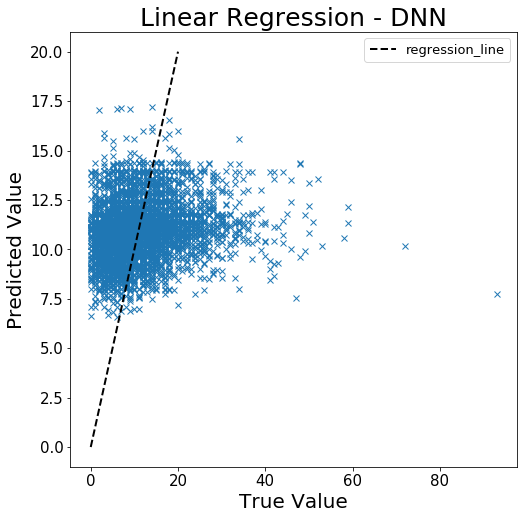

In [20]:
plt.figure(figsize=(8,8))

plt.rc('axes', titlesize=25)   
plt.rc('axes', labelsize=20)  
plt.rc('xtick', labelsize=15)   
plt.rc('ytick', labelsize=15) 
plt.rc('legend', fontsize=13)

plt.plot(y_test, pred,  'x')
plt.plot([0,20],[0,20], 'k--', linewidth=2, label="regression_line")
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Linear Regression - DNN')
plt.legend()

plt.savefig('result/img/reg_dnn.png', dpi=300)

##### Pred, True, Error table

In [21]:
pred = pred.reshape(6481,)

In [22]:
c = {'y_true': y_test, 'pred': pred.round()}

pred_diff = pd.DataFrame(data=c).reset_index()
pred_diff = pred_diff.drop(['index'], axis=1).reset_index(drop=True)
pred_diff.tail()

,pred,y_true
6476,11.0,11
6477,11.0,17
6478,11.0,16
6479,10.0,15
6480,12.0,11


In [23]:
pred_diff.to_csv('reg_dnn.csv', encoding='utf-8', index=False, line_terminator='\n')

## OLS Estimation

##### 데이터 로드

In [24]:
x_ols = X
y_ols = Y

##### 정규화 적용

In [25]:
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_ols)
x_ols = pd.DataFrame(x_scaled)

##### 일관성을 위한 코드
- shuffle과 random_seed 값 1004를 적용하여 일관성 있는 순서를 위해 아래 코드가 사용됨

In [26]:
x_ols, _, y_ols, _ = train_test_split(x_ols, y_ols, 
                                      test_size=0.01, 
                                      shuffle = True, 
                                      random_state = 1004)

colname = ['sex', 'intubed','age_grp','pneumonia',
           'pregnancy', 'diabetes', 'copd', 'asthma',
           'inmsupr','hypertension','other_disease',
           'cardiovascular','obesity', 'renal_chronic', 
           'tobacco', 'contact_other_covid', 'covid_res', 
           'icu']

x_ols = x_ols.reset_index(drop=True)
x_ols.columns = colname
y_ols = y_ols.reset_index(drop=True)

FD = sm.OLS(endog=y_ols, exog=x_ols).fit()
FD.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              diff_days   R-squared (uncentered):                   0.690
Model:                            OLS   Adj. R-squared (uncentered):              0.689
Method:                 Least Squares   F-statistic:                              3958.
Date:                Wed, 14 Oct 2020   Prob (F-statistic):                        0.00
Time:                        22:36:56   Log-Likelihood:                     -1.0976e+05
No. Observations:               32077   AIC:                                  2.196e+05
Df Residuals:                   32059   BIC:                                  2.197e+05
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
sex                     0.3546      0.088      4.013      0.000       0.181       0.528
intubed                -1.9579      0.267     -7.333      0.000      -2.481      -1.435
age_grp                -0.1120      0.212     -0.527      0.598      -0.528       0.304
pneumonia              -0.3643      0.101     -3.597      0.000      -0.563      -0.166
pregnancy              21.9722      0.718     30.595      0.000      20.565      23.380
diabetes                1.0614      0.181      5.866      0.000       0.707       1.416
copd                    0.9882      0.359      2.749      0.006       0.284       1.693
asthma                 -1.2470      0.534     -2.334      0.020      -2.294      -0.200
inmsupr                 0.9972      0.421      2.367      0.018       0.172       1.823
hypertension            0.0381      0.184      0.206      0.836      -0.323       0.399
other_disease           0.3785      0.327      1.158      0.247      -0.262       1.019
cardiovascular          1.0272      0.343      2.994      0.003       0.355       1.700
obesity                 0.0742      0.197      0.376      0.707      -0.312       0.461
renal_chronic           2.1117      0.313      6.744      0.000       1.498       2.725
tobacco                -0.8295      0.283     -2.929      0.003      -1.384      -0.274
contact_other_covid     0.8173      0.139      5.862      0.000       0.544       1.091
covid_res              -2.5513      0.148    -17.232      0.000      -2.842      -2.261
icu                    -3.4075      0.299    -11.387      0.000      -3.994      -2.821
==============================================================================
Omnibus:                    11464.577   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            57474.659
Skew:                           1.664   Prob(JB):                         0.00
Kurtosis:                       8.650   Cond. No.                         38.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Classification report

In [27]:
pred2 = FD.predict(x_ols)
rmse2 = np.sqrt(mean_squared_error(y_ols, pred2))
mse2 = mean_squared_error(y_ols, pred2)
print('MSE : %.3f' % (mse))
print('RMSE : %.3f' % (rmse))

MSE : 52.509
RMSE : 7.246


## 시각화

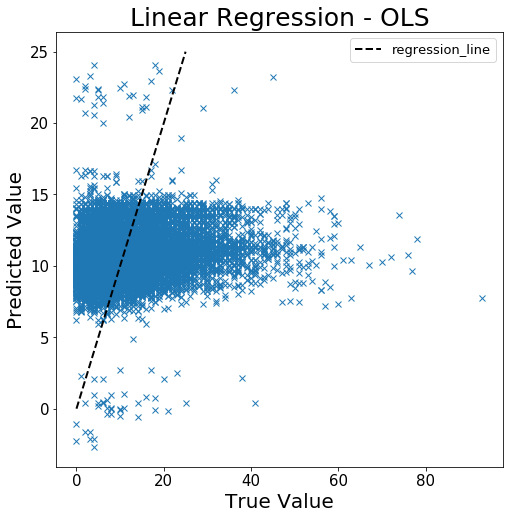

In [28]:
plt.figure(figsize=(8,8))
plt.rc('axes', titlesize=25)   
plt.rc('axes', labelsize=20)  
plt.rc('xtick', labelsize=15)   
plt.rc('ytick', labelsize=15) 
plt.rc('legend', fontsize=13)

plt.plot(y_ols, pred2, 'x')
plt.plot([0,25],[0,25], 'k--', linewidth=2, label="regression_line")
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.title('Linear Regression - OLS')

plt.legend()

plt.savefig('result/img/reg_ols.png', dpi=300)

#####  Predicted, True, Error table

In [29]:
d = { 'y_true': y_ols, 
      'y_pred': pred2.round(), 
      #'error': y_ols - pred2.round()}
    }

pred_diff2 = pd.DataFrame(data=d).reset_index()
pred_diff2 = pred_diff2.drop(['index'], axis=1)

In [30]:
c = {'y_true': y_test, 'pred': pred.round()}

pred_diff2 = pd.DataFrame(data=c).reset_index()
pred_diff2 = pred_diff2.drop(['index'], axis=1).reset_index(drop=True)
pred_diff2.tail()

,pred,y_true
6476,11.0,11
6477,11.0,17
6478,11.0,16
6479,10.0,15
6480,12.0,11


In [31]:
pred_diff2.tail()

,pred,y_true
6476,11.0,11
6477,11.0,17
6478,11.0,16
6479,10.0,15
6480,12.0,11


In [32]:
pred_diff2.to_csv('reg_ols.csv', encoding='utf-8', index=False, line_terminator='\n')

- 참고로 OLS는 train/test 를 구분하지 않기 때문에 csv에 모든 예측 결과값이 저장됨
- 총 32402개의 데이터가 입력되었음